In [82]:
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
from scipy import stats
import itertools
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib

np.random.seed(42)

# Clustering
## k-means, hierarchical, and more!

#### Mostly Jack Bennetto, with additions by Brandon Martin-Anderson
#### June 25, 2019

## Objectives
* Describe clustering
* Implement the within-cluster sum-of-squares metric
* Describe how to implement the k-means algorithm
* Choose K with the elbow method and silhouette score
* Describe hierarchical clustering
* List 3-4 cluster distance functions

## Clustering Problem

The goal of clustering is to divide the data into **distinct subgroups** such that observations within each group are similar.

![](images/clusters.png)


## Various Algorithms

There are several approaches to clustering, each with variations.

* k-means clustering
* Hierarchical clustering
* Density-based clustering (DBSCAN)
* Distribution-based clustering
* [the list goes on](https://scikit-learn.org/stable/modules/clustering.html)

How do we measure how good the clustering is?

## Within-Cluster Sum of Squares

Measures the goodness of a clustering

$$W(C) = \sum_{k=1}^{K} \sum_{i \in S_k}  || x_i - x_k ||^2 $$

where $K$ is the number of clusters, $S_k$ is the set of points in cluster $k$, and $x_j$ is the center of cluster $k$.

$W(C)$ is the sum of the square of the distances between all points and the center of the cluster to which they'd been assigned.



In [2]:
X, y = make_blobs(centers=[(0,0), (10,10)])

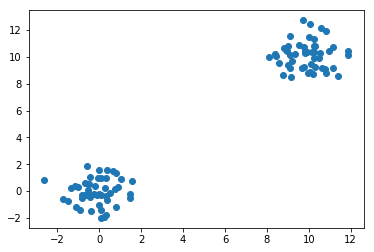

In [3]:
plt.scatter(*X.T)

Suppose we hypothesis cluster centers:

Suppose we assign points to two clusters, but poorly:

In [4]:
yhat = X.T[0]>9

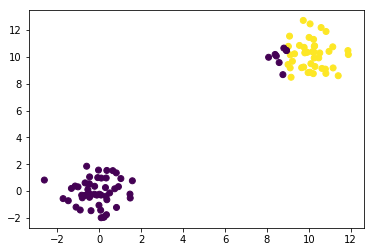

In [5]:
plt.scatter(*X.T, c=yhat)

The centroids of the clusters are:

In [6]:
cluster_0 = X[yhat==0].mean(axis=0)
cluster_1 = X[yhat==1].mean(axis=0)

cluster_0, cluster_1

(array([1.07176689, 1.31891947]), array([10.14954988, 10.16440246]))

Find the first cluster we can compute $$\sum_{i \in S_0}  || x_i - x_{k=0} ||^2 $$

In [7]:
aa = X[yhat==0] - cluster_0       # find diff of every cluster minus centroid
bb = np.linalg.norm( aa, axis=1 ) # find norm
cc = bb**2                        # square norm
cluster_0_sum_squares = cc.sum()  # sum squares
cluster_0_sum_squares

1314.8485755170423

Likewise for the second cluster

In [8]:
aa = X[yhat==1] - cluster_1       # find diff of every cluster minus centroid
bb = np.linalg.norm( aa, axis=1 ) # find norm
cc = bb**2                        # square norm
cluster_1_sum_squares = cc.sum()  # sum squares
cluster_1_sum_squares

69.26795309499073

Sum the within-cluster sum of squares to find the total within-cluster sum of squares.

In [9]:
cluster_0_sum_squares + cluster_1_sum_squares

1384.116528612033

To this we could compare a much better clustering:

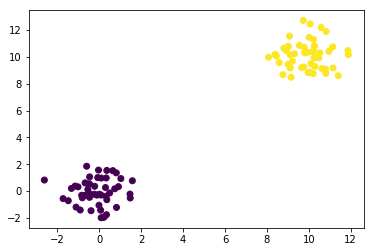

In [10]:
plt.scatter(*X.T, c=y)

In [11]:
def within_cluster_sum_of_squares(X, y, cluster):
    cluster_mean = X[y==cluster].mean(axis=0)
    
    return (np.linalg.norm((X[y==cluster] - cluster_mean), axis=1)**2).sum()

sum( [within_cluster_sum_of_squares(X, y, i) for i in range(2)] )

170.20319336001373

A better clustering, by this metric.

Do you need to normalize/standardize the data?

# k-means Algorithm

The k-means algorithm involves repeatedly assigning points to clusters and then finding new clusters based on those points.

* Choose a number of clusters k
* 1\. Choose initial clusters
* 2\. Repeatedly:
    * a\. For each of k clusters, compute cluster *centroid* by taking
mean vector of points in the cluster
    * b\. Assign each data point to cluster for which centroid is closest
(Euclidean)

...until clusters stop changing

This approach can be seen as simple version of an **Expectation-Maximization** algorithm. The step of choosing a new centroid is called a *maximization* step, finding the best cluster center given some data. The assignment of data points is the *expectation* step, finding the expected cluster for each point.

Discussion: how should we choose initial clusters? Does it matter?

# k-means Algorithm

![The k-means algorithm.](images/kmeans.png)

The k-means algorithm is **not** guaranteed to find the best clustering. A common adaption is to run it several times, and pick the best solution. `sklearn`'s kmeans implementation runs 10 times by default.

## What's the correct number of clusters?

This morning we talked about the "best" way to divide data into a given number of clusters, but what number is best?

In [12]:
clusters = [(-2, -3, .75, 100),
            (-5, -5, .75, 75),
            (4, 3, 1.5, 200),
            (1, -3, .5, 150),
            (-1, 0.15, 0.75, 100)]
k = len(clusters)
n = sum([c[3] for c in clusters])

allpts = []

# for each cluster
for x_mean, y_mean, std, count in clusters:
    # get a little 2-dimensional normal scattering 
    pts = stats.multivariate_normal(mean=(x_mean,y_mean), cov=std**2).rvs(count)
    
    allpts.append( pts )
X = np.vstack(allpts)


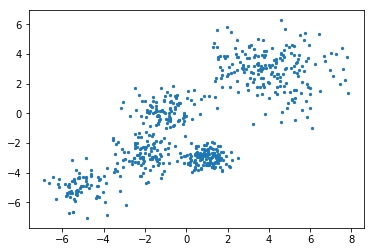

In [13]:
plt.scatter(*X.T, s=5)

How many clusters do you see?

Let's try fitting them with k-means.

In [18]:
km = KMeans(5)
y = km.fit_predict(X)

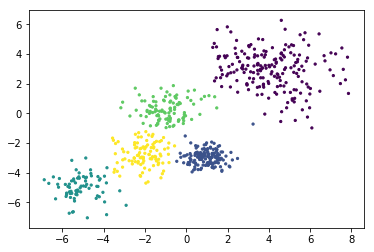

In [19]:
plt.scatter(*X.T, s=5, c=y)

These are basically the clusters we created the data from.

# Choosing K

Can we just use within-cluster sum of squares (WCSS) to choose k?

More clusters $\implies$ lower WCSS.

So why not just give each data point its own cluster?

There are several measures for the "best" k, and no easy answer

 * The Elbow Method
 * Silhouette Score
 * GAP Statistic

First, let's cluster the data above with k-means with various values of $k$.

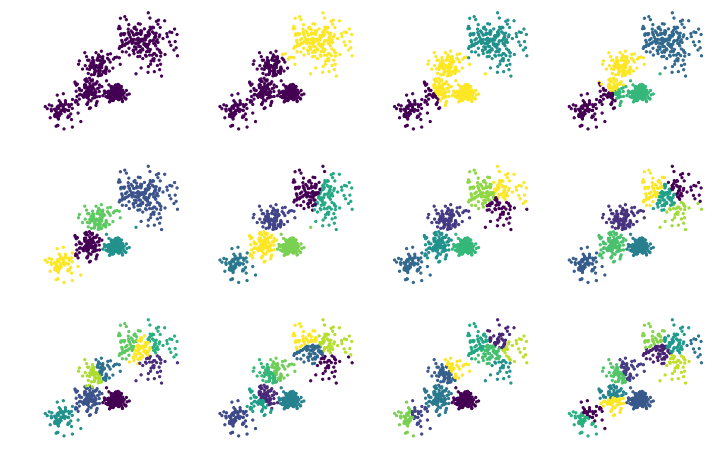

In [76]:
def sum_within_cluster_sum_of_squares(X, y):
    tmp = []
    for i in range(max(y)+1):
        tmp.append( within_cluster_sum_of_squares(X,y,i) )
    return sum( tmp )

nrows, ncols = 3, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(12,8))

wcss = []
silhouette = []
for i in range(nrows):
    for j in range(ncols):
        k = i*ncols+j + 1
        y = KMeans(k).fit_predict(X)
        
        wcss.append( sum_within_cluster_sum_of_squares(X,y) )
        if k>1:
            silhouette.append( silhouette_score(X,y) )
        else:
            silhouette.append(0)
        
        ax = axs[i][j]
        ax.axis('off')
        ax.scatter( *X.T, c=y, s=5 )

## The Elbow Method

Let's start with the Elbow method. In this, we simply plot the within-cluster sum of squares and try to see what looks like an elbow.

What looks best?

Text(0, 0.5, 'within-cluster sum of squares')

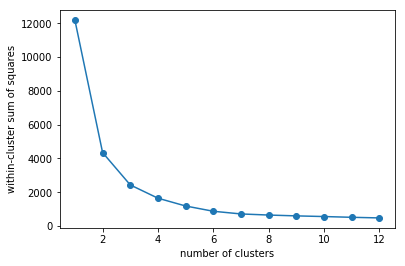

In [78]:
fig, ax = plt.subplots()
ax.plot(range(1,len(wcss)+1), wcss, 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("within-cluster sum of squares")

What we want is some metric we can maximize.

What would that look like?

# Choosing K -- Silhouette Score

For each point $x_i$:

 * $a(i)$ average dissimilarity of $x_i$ with points in the same cluster
 * $b(i)$ average dissimilarity of $x_i$ with points in the nearest cluster
    * "nearest" means cluster with the smallest $b(i)$

$$\text{silhouette}(i) = \frac{b(i) - a(i)}{max(a(i), b(i))} $$

What's the range of silhouette scores?

The silhouette score of a clustering is the average of silhouette score of all points.

Text(0, 0.5, 'silhouette score')

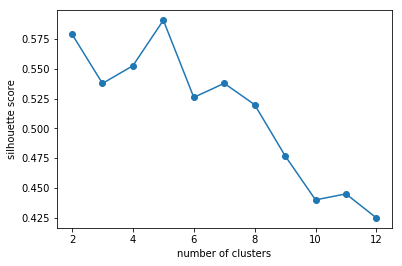

In [80]:
fig, ax = plt.subplots()
ax.plot(range(2,13), silhouette[1:12], 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("silhouette score")
#ax.set_ylim(ymin=0.0, ymax=1.0)

Possible silhouette scores:
 * near 1: very small tight cluster.
 * 0: at the edge of two clusters; could be in either.
 * < 0: oops.

The higher the the average silhouette score, the tighter and more separated the clusters.

# Silhouette Graph

A silhouette graph is a representation of the silhouette score of ever data point, grouped first by cluster and then in decreasing value.

For more information, [read about silhouette graphs here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

# Hierarchical Clustering

With many clustering methods the goal is to divide the data into a specific number of clusters. With hierarchical clustering we group data points as leaves on a tree, clustering them into larger and larger groups.

How would we group these?

![](images/letters-ungrouped.png)


<table><tr><td><img src='images/letters-grouped.png'></td><td><img src='images/letters-dendrogram.png'></td></tr></table>


# Hierarchical Clustering

The basic algorithm of hierarchical clustering is

 * Assign each point to its own cluster
 * Repeat:

   * Compute distances between clusters
   * Merge closest clusters

 ...until all are merged

How do we define dissimilarity between clusters?

## Linkage

It's easy to talk about the distance (or dissimilarity) between two points, but between clusters it's less clear. There are a few different measures used.

* **Complete:** Maximum pairwise dissimilarity between points in clusters -- good
* **Average:** Average of pairwise dissimilarity between points in clusters -- also good
* **Single:** Minimum pairwise dissimilarity between points in clusters -- not as good; can lead to long narrow clusters
* **Centroid:** Dissimilarity between centroids -- used in genomics; risk of inversions

# Problems with k-means and other methods

k-means has limitations.

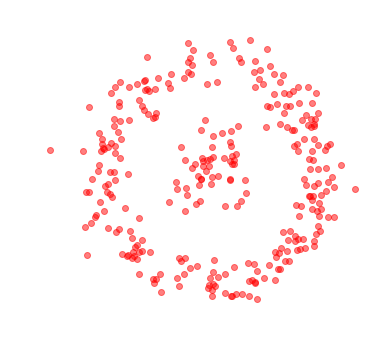

In [85]:
fig, ax = plt.subplots(figsize=(6,6))
r = np.concatenate([stats.norm(8,1).rvs(250),
                    stats.norm(2,1).rvs(50)])
a = stats.uniform(0, 6.28).rvs(300)
x = r * np.cos(a)
y = r * np.sin(a)

ax.axis('equal')
ax.axis('off')
ax.scatter(x, y, color="r", alpha=0.5)

Again, check out [performance of clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html)